## AI Agent Bhorali

### An AI Agent that given a token address returns a full analysis report for the token/

In [3]:
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from IPython.display import Image
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt.chat_agent_executor import AgentState
import requests
from pydantic import BaseModel, Field

# web3
from web3 import Web3
from solana.rpc.async_api import AsyncClient
import asyncio
import base64

In [4]:
class AgentState(TypedDict):
    token: str # address of the token

    price_pattern_analysis: str # output of the price pattern analysis by one node
    token_distribution_analysis: str # output of the token distribution analysis by one node
    whales_analysis: str # output of the whales analysis by one node
    volume_pattern_analysis: str # output of the volume pattern analysis by one node
    token_news_analysis: str # output of the token news analysis by one node

    final_report: str # final report of the token analysis by master node

chain = "Ethereum"

prompt_end = f"""Analyze the price pattern data provided to you below for a token on {chain} and provide a detailed report detailing your critique of the investment potential in the token.
                Your report will be forwarded to another investment expert node which will create a final report after analysing the data from you and from other similar nodes. 
                So make sure to structure your report best for analysis by your successive agent.
                
                Note: If there is no useful information for analysis, just say "No useful information for analysis"."""


PRICE_PATTERN_ANALYSIS_PROMPT = f"""You are an expert Price Pattern Analyst. {prompt_end}"""

TOKEN_DISTRIBUTION_ANALYSIS_PROMPT = f"""You are an expert crypto Investment Analyst for token distribution data. {prompt_end}"""

WHALES_ANALYSIS_PROMPT = f"""You are an expert crypto investment analyst for whale addresses data. {prompt_end}"""

VOLUME_PATTERN_ANALYSIS_PROMPT = f"""You are an expert crypto investment Analyst for volume pattern data. {prompt_end}"""

TOKEN_NEWS_ANALYSIS_PROMPT = f"""You are an expert crypto investment analyst given the news for the token. {prompt_end}"""

FINAL_REPORT_PROMPT = """You are an expert crypto investment analyst tasked with creating a COMPREHENSIVE and DETAILED investment report.

Your mission is to analyze all reports provided to you and create an exhaustive final report that includes ALL important information from each analysis section. Do not summarize or condense information excessively.

For each section, provide extensive details backed by data points from the original reports.

Provide specific trading recommendations with entry/exit strategies where possible.

Conclude with your professional opinion and a formal "Not Financial Advice" disclaimer. Remember to be thorough - investors rely on your comprehensive analysis to make informed decisions."""



In [5]:
from onchain.utils import get_web3
import json

ERC20_ABI = json.load(open("onchain/abis/ERC20.json"))


def get_token_name(token_address: str) -> str:
    """Returns the name of a token from its address"""
    web3 = get_web3()
    contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)
    return contract.functions.name().call()


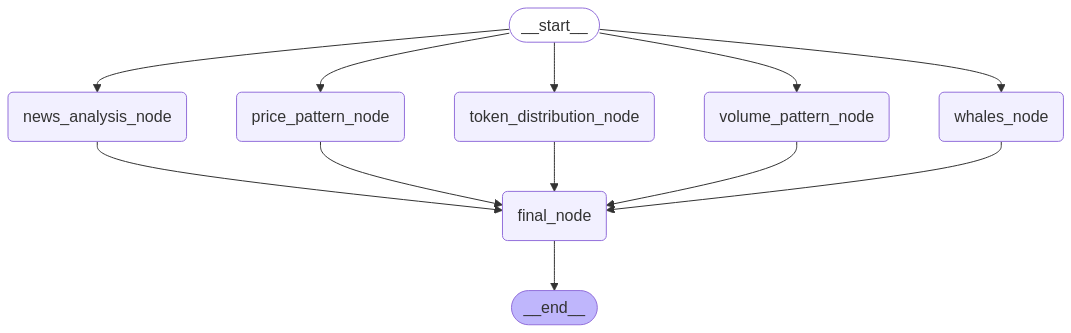

In [6]:
from onchain.price_pattern import analyze_technical_indicators, visualize_technical_analysis, get_essential_indicators
from onchain.volume_pattern import analyze_token_volume_comprehensive, visualize_volume_analysis, get_ohlcv_data, get_volume_snapshot
from onchain.token_distribution import analyze_token_distribution
from onchain.whales import monitor_whale_wallets

import matplotlib.pyplot as plt


search_tool = TavilySearchResults(max_results=8)

class TokenAgent:

    def __init__(self, model):
        graph_builder = StateGraph(AgentState)
        memory = MemorySaver()
        self.llm = model

        graph_builder.add_node("price_pattern_node", self.price_pattern_node)
        graph_builder.add_node("token_distribution_node", self.token_distribution_node)
        graph_builder.add_node("whales_node", self.whales_node)
        graph_builder.add_node("volume_pattern_node", self.volume_pattern_node)
        graph_builder.add_node("news_analysis_node", self.token_news_node)
        graph_builder.add_node("final_node", self.final_report_node)

        graph_builder.add_edge(START, "price_pattern_node")
        graph_builder.add_edge(START, "token_distribution_node")
        graph_builder.add_edge(START, "whales_node")
        graph_builder.add_edge(START, "volume_pattern_node")
        graph_builder.add_edge(START, "news_analysis_node")

        graph_builder.add_edge("price_pattern_node", "final_node")
        graph_builder.add_edge("token_distribution_node", "final_node")
        graph_builder.add_edge("whales_node", "final_node")
        graph_builder.add_edge("volume_pattern_node", "final_node")
        graph_builder.add_edge("news_analysis_node", "final_node")

        graph_builder.add_edge("final_node", END)

        self.graph = graph_builder.compile(checkpointer=memory)


    def price_pattern_node(self, state: AgentState):
        ohlcv_data = get_ohlcv_data(state['token'])
        raw_full_report = analyze_technical_indicators(ohlcv_data)

        fig = visualize_technical_analysis(ohlcv_data, raw_full_report)

        temp_plot_path = "temp_technical_analysis.png"
        fig.savefig(temp_plot_path, bbox_inches='tight', dpi=300)
        plt.close(fig)  # Close specific figure to free memory

        # Verify the file exists and has content
        if not os.path.exists(temp_plot_path) or os.path.getsize(temp_plot_path) == 0:
            print("Warning: Plot file is empty or not created")
            return {"price_pattern_analysis": "Error: Could not generate technical analysis visualization"}

        # Convert image to base64
        with open(temp_plot_path, "rb") as image_file:
            image_data = base64.b64encode(image_file.read()).decode("utf-8")

        raw_report = get_essential_indicators(raw_full_report)

        prompt = f"""
                {PRICE_PATTERN_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}

                Please analyze the technical indicators shown in the attached chart image.
                """

        # Create message list with image in correct format
        messages = [
            SystemMessage(content=prompt),
            HumanMessage(
                content=[
                    {
                        "type": "text", 
                        "text": "Please analyze this technical analysis chart along with the data provided."
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_data}"}
                    }
                ]
            )
        ]

        response = self.llm.invoke(messages)
        
        # Clean up temporary file
        if os.path.exists(temp_plot_path):
            os.remove(temp_plot_path)
            
        return {"price_pattern_analysis": response}
    
    def token_distribution_node(self, state: AgentState):
        raw_report = analyze_token_distribution(state['token'])
        prompt = f"""
                {TOKEN_DISTRIBUTION_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"token_distribution_analysis": response}
    
    def whales_node(self, state: AgentState):
        raw_report = monitor_whale_wallets(state['token'], days=3)
        prompt = f"""
                {WHALES_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"whales_analysis": response}
    
    def volume_pattern_node(self, state: AgentState):
        ohlcv_data = get_ohlcv_data(state['token'])
        raw_full_report = analyze_token_volume_comprehensive(state['token'], ohlcv_data)
        raw_report = get_volume_snapshot(raw_full_report)

        fig = visualize_volume_analysis(ohlcv_data, raw_full_report)

        temp_plot_path = "temp_volume_analysis.png"
        fig.savefig(temp_plot_path, bbox_inches='tight', dpi=300)
        plt.close(fig)  # Close specific figure to free memory

        # Verify the file exists and has content
        if not os.path.exists(temp_plot_path) or os.path.getsize(temp_plot_path) == 0:
            print("Warning: Plot file is empty or not created")
            return {"volume_pattern_analysis": "Error: Could not generate volume analysis visualization"}

        # Convert image to base64
        with open(temp_plot_path, "rb") as image_file:
            image_data = base64.b64encode(image_file.read()).decode("utf-8")
            
        
        prompt = f"""
                {VOLUME_PATTERN_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}

                Please analyze the volume pattern data provided to you below.
                """

        # Create message list with image in correct format
        messages = [
            SystemMessage(content=prompt),
            HumanMessage(
                content=[
                    {
                        "type": "text", 
                        "text": "Please analyze this volume pattern chart along with the data provided."
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_data}"}
                    }
                ]
            )
        ]

        response = self.llm.invoke(messages)

        return {"volume_pattern_analysis": response}
    
    def token_news_node(self, state: AgentState):

        # get token name from token address
        token_name = get_token_name(state['token'])

        search_query = f"Token: {token_name}; Chain: {chain}; cryptocurrency news"
        search_results = search_tool.invoke(search_query, search_depth="advanced")

        # Extract relevant news from search results
        news_items = []
        for result in search_results:
            news_items.append(result['content'])
        
        prompt = f"""
                {TOKEN_NEWS_ANALYSIS_PROMPT}   

                Token address: {state['token']}
                Token name: {token_name}

                News: {news_items}
                """

        response = self.llm.invoke(prompt)
        return {"token_news_analysis": response}
    
    def final_report_node(self, state: AgentState):
        prompt = f"""
                {FINAL_REPORT_PROMPT}

                Token address: {state['token']}

                Price pattern analysis: {state['price_pattern_analysis']}

                Token distribution analysis: {state['token_distribution_analysis']}
                Note: Its a sample from the top 100 holders and not all holders.


                Whales analysis: {state['whales_analysis']} (Support your summary with whale addresses too)
                Volume pattern analysis: {state['volume_pattern_analysis']}
                Token news analysis: {state['token_news_analysis']}
                """

        response = self.llm.invoke(prompt)
        
        return {"final_report": response}
    
    def show_graph(self):
        return Image(self.graph.get_graph().draw_mermaid_png())

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
agent = TokenAgent(model)

agent.show_graph()

In [7]:
    
thread = {"configurable": {"thread_id": "1"}}
state = agent.graph.invoke({"token": "0xfAbA6f8e4a5E8Ab82F62fe7C39859FA577269BE3"}, thread)

print(state['final_report'])

/Users/diganta/Desktop/ai/langchain-test/bhorali/onchain/price_pattern.py:707: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(
/Users/diganta/Desktop/ai/langchain-test/bhorali/onchain/volume_pattern.py:867: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.88])


content='# Comprehensive Investment Report for ONDO Token (0xfAbA6f8e4a5E8Ab82F62fe7C39859FA577269BE3)\n\n## Executive Summary\nThe ONDO token, associated with Ondo Finance, is positioned to capitalize on the burgeoning market for tokenized real-world assets (RWAs). With a total supply of 10 billion tokens and significant institutional backing, including partnerships with BlackRock and Franklin Templeton, ONDO presents a compelling investment opportunity. This report synthesizes technical analysis, token distribution, whale activity, volume patterns, and recent news developments to provide a comprehensive overview of the investment potential of ONDO.\n\n---\n\n## 1. Technical Analysis\n\n### Current Market Data\n- **Current Price**: $1.35\n- **Bollinger Bands**:\n  - **Middle Band**: $1.35\n  - **Upper Band**: $1.41\n  - **Lower Band**: $1.29\n  - **Volatility**: 0.0877\n- **VWAP**: $1.29 (Current: Above VWAP)\n- **Overall Bias**: Bullish\n\n### Chart Analysis\n1. **Price Action**: The